### Setup

Import Caffe and the usual modules.

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.mlab import PCA

%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import _init_paths
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import _get_blobs
from utils.cython_nms import nms
from utils.timer import Timer
import scipy.io as sio
import caffe, os, sys, cv2, h5py

### Configure all the constants

Define net path, data path and so on.

In [5]:
DATA_PATH = '/mnt/wb/dataset/LINEMOD4FRCNN'
COMP_DATA_PATH = '/mnt/wb/dataset/LINEMOD_COMP4FRCNN'
V_DATA_PATH = '/mnt/wb/dataset/LINEMOD_V4FRCNN'
REALBG_DATA_PATH = '/mnt/wb/dataset/LINEMOD_BG4FRCNN'
ROR_DATA_PATH = '/mnt/wb/dataset/LINEMOD_ROR4FRCNN'
FRCNN_ROOT_DIR = '/mnt/wb/project/fast-rcnn'

CLASSES = ('__background__',
           'ape', 'benchviseblue', 'bowl', 'cam', 'can', 
           'cat', 'cup', 'driller', 'duck', 'eggbox', 
           'glue', 'holepuncher', 'iron', 'lamp', 'phone')

NETS = {'detect_net_comp_500k': ('wb_CaffeNet',
                     'test_linemod.prototxt',
                     'caffenet_comp_2_iter_2000000.caffemodel'),
       'detect_net_small_2000k': ('wb_SmallNet',
                     'test_linemod.prototxt',
                     'smallnet_comp_2_iter_2000000.caffemodel')}

DATASETS = {'linemod_test': (DATA_PATH + '/data/ImageSets/test.txt',
                  DATA_PATH + '/test.mat'),
            'linemod_comp_test': (COMP_DATA_PATH + '/data/ImageSets/test.txt',
                  COMP_DATA_PATH + '/test.mat'),
            'linemod_comp_train': (COMP_DATA_PATH + '/data/ImageSets/train.txt',
                  COMP_DATA_PATH + '/train.mat'),
            'linemod_v_test': (V_DATA_PATH + '/data/ImageSets/test.txt',
                  V_DATA_PATH + '/test.mat'),
            'linemod_v_train': (V_DATA_PATH + '/data/ImageSets/train.txt',
                  V_DATA_PATH + '/train.mat'),
           'linemod_realbg_train': (REALBG_DATA_PATH + '/data/ImageSets/train.txt',
                  REALBG_DATA_PATH + '/train.mat'),
           'linemod_ror_train': (ROR_DATA_PATH + '/data/ImageSets/train.txt',
                  ROR_DATA_PATH + '/train.mat')}

CFG_FILE = FRCNN_ROOT_DIR+'/experiments/wb_cfgs/linemod_comp_2.yml'

GPU_ID = 10

prototxt = os.path.join(FRCNN_ROOT_DIR, 'models', NETS['detect_net_small_2000k'][0],
                            NETS['detect_net_small_2000k'][1])
caffemodel = os.path.join(FRCNN_ROOT_DIR, 'output', 'LINEMOD',
                              NETS['detect_net_small_2000k'][2])

images = DATASETS['linemod_comp_test'][0]

### Load net

In [6]:
cfg_from_file(CFG_FILE)

caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

### Load data

Load images and proposals

In [7]:
image_names = [line.strip() for line in open(images).readlines()]
image_pathes = ['{0}/{1}/{2}{3}'.format(COMP_DATA_PATH, 'data/Images', image_name, '.jpg')\
                for image_name in image_names]
img_num = len(image_names)
image_boxes = [0 for i in range(img_num)]
image_boxes_cls = [0 for i in range(img_num)]

for i in range(img_num):
    filename = os.path.join(COMP_DATA_PATH, 'data', 'Annotations', image_names[i] + '.txt')
    # print 'Loading: {}'.format(filename)
    with open(filename) as f:
        data = f.readlines()

    objs = data
    num_objs = len(objs)
    boxes = np.zeros((num_objs, 4), dtype=np.uint16)
    gt_classes = np.zeros((num_objs), dtype=np.int32)

    # Load object bounding boxes into a data frame.
    for ix, obj in enumerate(objs):
        # Make pixel indexes 0-based
        cls_bb = obj.strip().split(' ')
        cls_name = cls_bb[0]
        x1 = float(cls_bb[1])
        y1 = float(cls_bb[2])
        x2 = float(cls_bb[3])
        y2 = float(cls_bb[4])
        cls = CLASSES.index(cls_name)
        boxes[ix, :] = [x1, y1, x2, y2]
        gt_classes[ix] = cls
    image_boxes[i] = boxes
    image_boxes_cls[i] = gt_classes

### Compute features
Compute features of last fully-connected layers

In [8]:
img_num=4
conv1_list = [ 0 for _ in range(img_num)]
pool1_list = [ 0 for _ in range(img_num)]
conv2s_list = [ 0 for _ in range(img_num)]
pool2s_list = [ 0 for _ in range(img_num)]
conv3s_list = [ 0 for _ in range(img_num)]
pool3s_list = [ 0 for _ in range(img_num)]
score_list = [ 0 for _ in range(img_num)]

#for i in range(img_num):
img_ids = [0, 666, 1900, 2600]
idx=0
for i in img_ids:
    print image_pathes[i]
    im = cv2.imread(image_pathes[i])
    # change the box format from matlab(1-based index, colomn major) to python format(0-based index, row major)
    boxes = image_boxes[i]
        
    blobs, unused_im_scale_factors = _get_blobs(im, boxes)

    # reshape network inputs
    net.blobs['data'].reshape(*(blobs['data'].shape))
    net.blobs['rois'].reshape(*(blobs['rois'].shape))
    
    feat_blobs_names = ['conv1', 'pool1','conv2_s', 'pool2_s', 'conv3_s', 'pool3_s', 'cls_prob']
    blobs_out = net.forward(blobs=feat_blobs_names, data=blobs['data'].astype(np.float32, copy=False),
                        rois=blobs['rois'].astype(np.float32, copy=False))
    
    score_list[idx] = np.copy(blobs_out['cls_prob'])
    conv1_list[idx] = np.copy(blobs_out['conv1'])
    pool1_list[idx] = np.copy(blobs_out['pool1'])
    conv2s_list[idx] = np.copy(blobs_out['conv2_s'])
    pool2s_list[idx] = np.copy(blobs_out['pool2_s'])
    conv3s_list[idx] = np.copy(blobs_out['conv3_s'])
    pool3s_list[idx] = np.copy(blobs_out['pool3_s'])
    
    idx = idx + 1

/mnt/wb/dataset/LINEMOD_COMP4FRCNN/data/Images/ape_color0.jpg
/mnt/wb/dataset/LINEMOD_COMP4FRCNN/data/Images/ape_color666.jpg
/mnt/wb/dataset/LINEMOD_COMP4FRCNN/data/Images/benchviseblue_color664.jpg
/mnt/wb/dataset/LINEMOD_COMP4FRCNN/data/Images/bowl_color149.jpg


In [9]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
  
print conv1_list[0].shape
print conv2s_list[0].shape
print conv3s_list[0].shape
print pool3s_list[0].shape

(1, 96, 120, 160)
(1, 16, 61, 81)
(1, 8, 31, 41)
(1, 8, 6, 6)


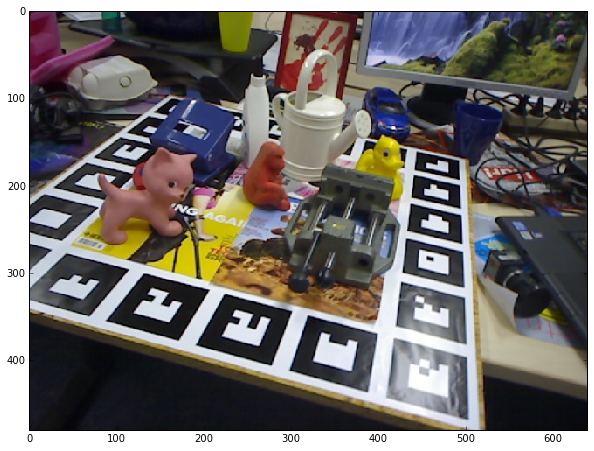

In [10]:
img_id = 1
im = cv2.imread(image_pathes[img_ids[img_id]])
im = im[:, :, (2, 1, 0)]
plt.imshow(im)

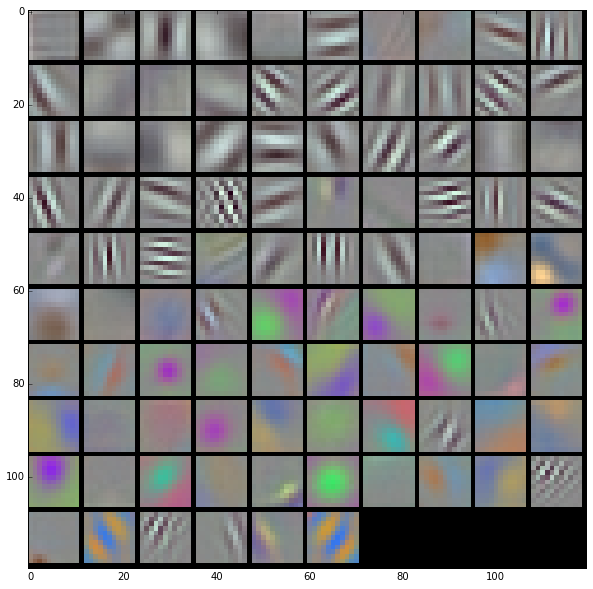

In [11]:
conv1 = net.params['conv1'][0].data
vis_square(conv1.transpose((0,2,3,1)))

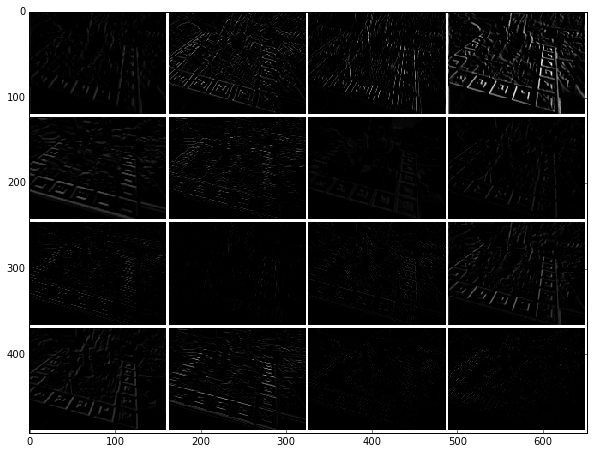

In [12]:
conv1_feat = conv1_list[img_id][0]
vis_square(conv1_feat[0:16],padsize=3, padval=1)

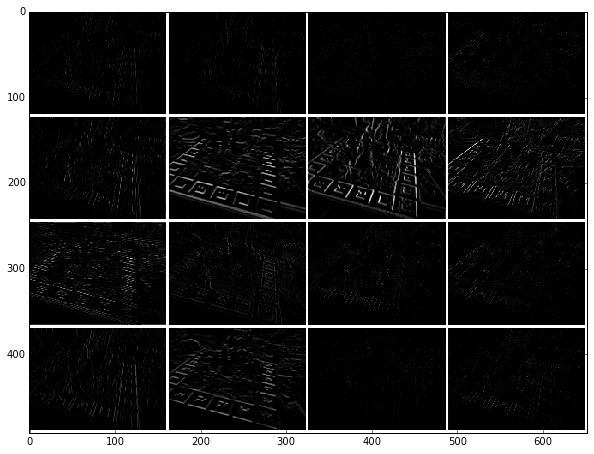

In [13]:
vis_square(conv1_feat[16:2*16],padsize=3, padval=1)

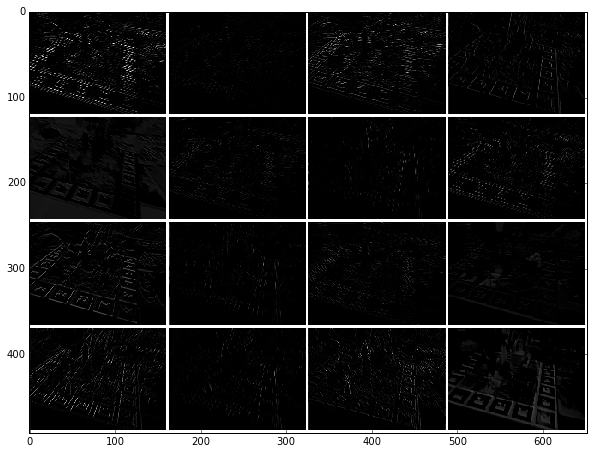

In [14]:
vis_square(conv1_feat[2*16:3*16],padsize=3, padval=1)

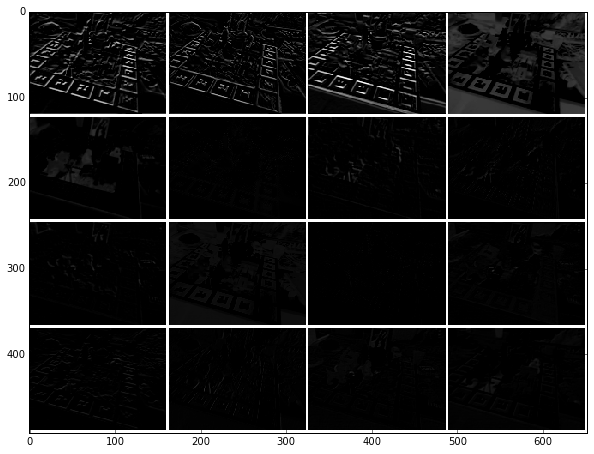

In [15]:
vis_square(conv1_feat[3*16:4*16],padsize=3, padval=1)

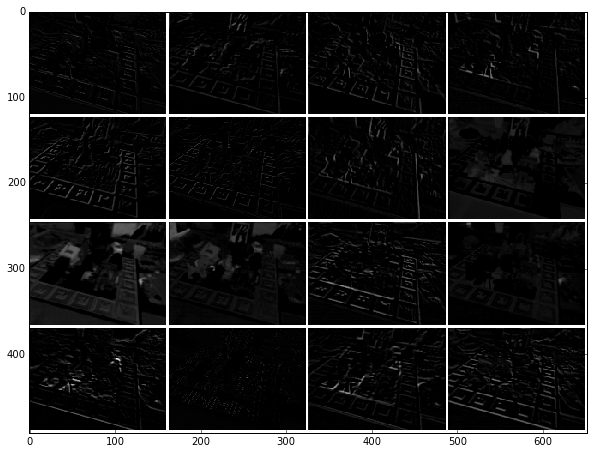

In [16]:
vis_square(conv1_feat[4*16:5*16],padsize=3, padval=1)

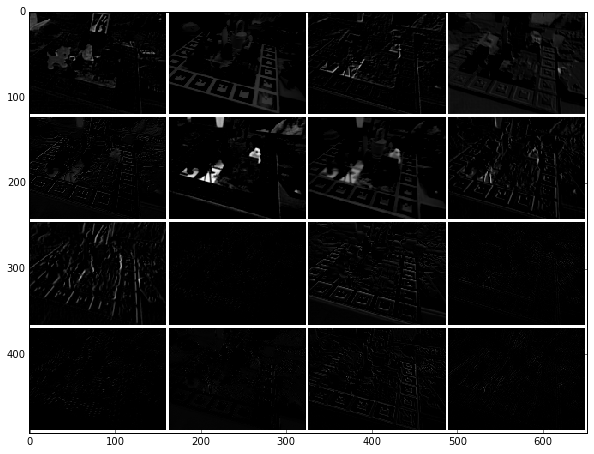

In [17]:
vis_square(conv1_feat[5*16:6*16],padsize=3, padval=1)

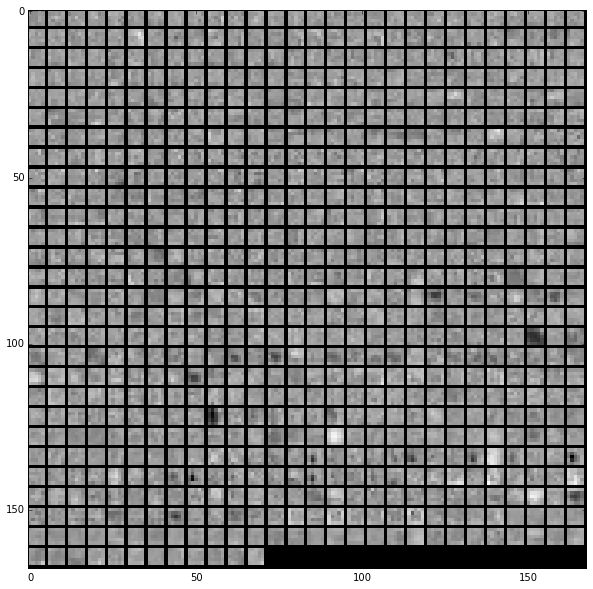

In [18]:
conv2s = net.params['conv2_s'][0].data
vis_square(conv2s[:].reshape(48*16,5,5))

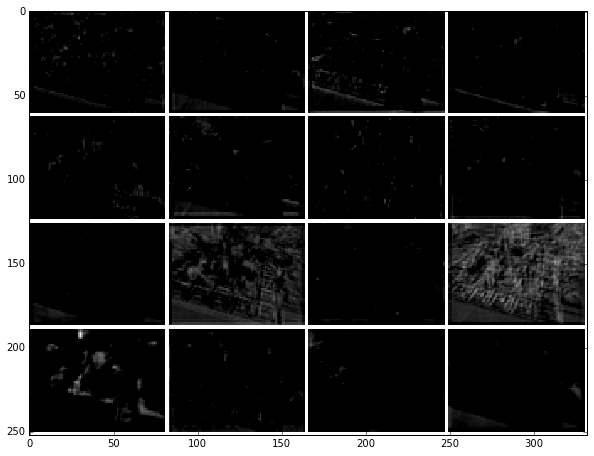

In [19]:
conv2s_feat = conv2s_list[img_id][0]
vis_square(conv2s_feat,padsize=2, padval=1)

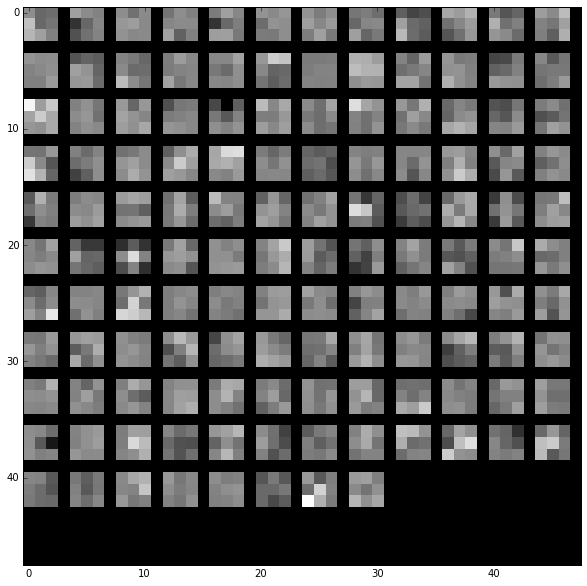

In [20]:
conv3s = net.params['conv3_s'][0].data
#conv3s.shape
vis_square(conv3s[:].reshape(8*16,3,3))

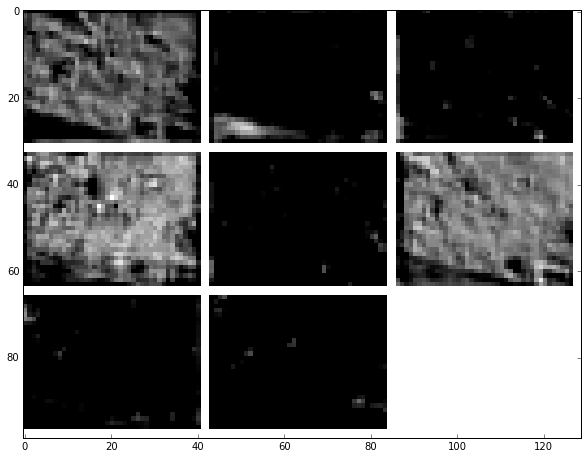

In [21]:
conv3s_feat = conv3s_list[img_id][0]
vis_square(conv3s_feat,padsize=2, padval=1)

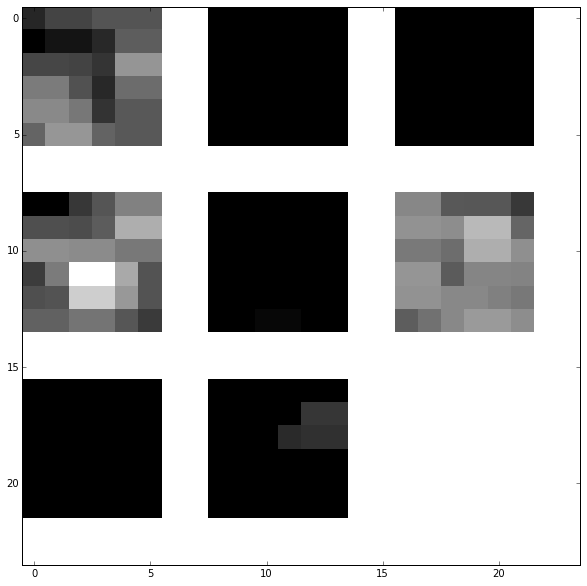

In [22]:
pool3s_feat = pool3s_list[img_id][0]
vis_square(pool3s_feat,padsize=2, padval=1)

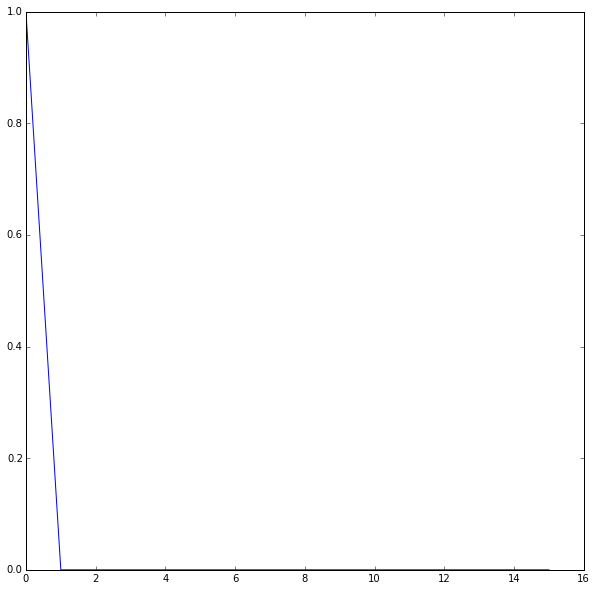

In [23]:
score = score_list[img_id]
plt.plot(score.flat)